In [18]:
import pandas as pd
exp = 'nothing'
HZ = '30hz'
re = "540p"
df_1x = pd.read_csv(f'/home/hanling/HunyuanVideo_efficiency/analysis_ci/analysis_results_{HZ}_{exp}_1x_{re}/raw_metrics_v2.csv')
df_2x = pd.read_csv(f'/home/hanling/HunyuanVideo_efficiency/analysis_ci/analysis_results_{HZ}_{exp}_2x_{re}/raw_metrics_v2.csv')
df_4x = pd.read_csv(f'/home/hanling/HunyuanVideo_efficiency/analysis_ci/analysis_results_{HZ}_{exp}_4x_{re}/raw_metrics_v2.csv')
# 创建一个 df, 只保留 file_name, chunk_idx, tile_ci 列。这里默认三个 csv 的 file_name, chunk_idx, tile_ci 相同。
df_merged = df_1x[['file_name', 'chunk_idx', 'tile_ci']].copy()

# 把 1x 中的 psnr/ssim/lpips 加入
df_merged['psnr_1x'] = df_1x['psnr']
df_merged['ssim_1x'] = df_1x['ssim']
df_merged['lpips_1x'] = df_1x['lpips']

# 把 2x 中的 psnr/ssim/lpips 加入
df_merged['psnr_2x'] = df_2x['psnr']
df_merged['ssim_2x'] = df_2x['ssim']
df_merged['lpips_2x'] = df_2x['lpips']

# 把 4x 中的 psnr/ssim/lpips 加入
df_merged['psnr_4x'] = df_4x['psnr']
df_merged['ssim_4x'] = df_4x['ssim']
df_merged['lpips_4x'] = df_4x['lpips']


In [20]:
import numpy as np

# 提取 tile_ci -> cc
tile_ci = df_merged['tile_ci'].values
cc = 1.0 - tile_ci
inds = np.argsort(cc)

# 准备存放所有结果的 dict
all_ssim = {}
all_psnr = {}
all_lpips = {}

all_ssim['1x'] = df_merged['ssim_1x'].values
all_ssim['2x'] = df_merged['ssim_2x'].values
all_ssim['4x'] = df_merged['ssim_4x'].values

all_psnr['1x'] = df_merged['psnr_1x'].values
all_psnr['2x'] = df_merged['psnr_2x'].values
all_psnr['4x'] = df_merged['psnr_4x'].values

all_lpips['1x'] = df_merged['lpips_1x'].values
all_lpips['2x'] = df_merged['lpips_2x'].values
all_lpips['4x'] = df_merged['lpips_4x'].values


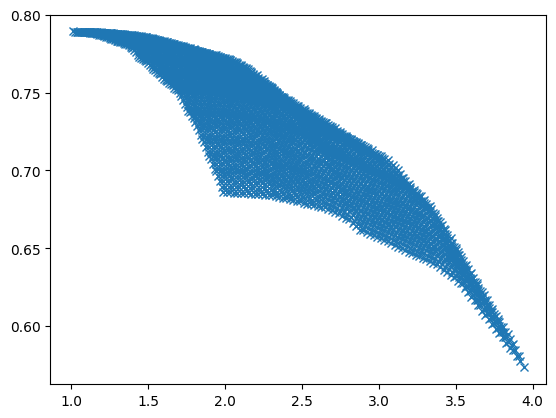

0.7892534090909091 26.287384090909097 0.07455454545454544
0.6825386363636363 24.04609431818182 0.11790568181818183
0.5622102272727273 21.840068181818182 0.172375
cr=2 => 0.7732852272727274 25.93565113636364 0.08184431818181817
cr=3 => 0.7130511363636365 24.20403409090909 0.10917386363636367
cr=6 => 0 0 9999


In [21]:
# 你已经有的计算 cr、tot_ssim、tot_psnr、tot_lpips 的部分
X = []
Y = []
best_ssim_2x = 0
best_ssim_3x = 0
best_psnr_2x = 0
best_psnr_3x = 0
best_lpips_2x = 9999
best_lpips_3x = 9999

# **这里加上 6x 的初始化变量**
best_ssim_1_5x = 0
best_psnr_1_5x = 0
best_lpips_1_5x = 9999
best_ssim_6x = 0
best_psnr_6x = 0
best_lpips_6x = 9999

for i in range(len(cc)):
    for j in range(i+1, len(cc)):
        x4_ssim = np.array(all_ssim['4x'])[inds[:i]].sum()
        x2_ssim = np.array(all_ssim['2x'])[inds[i:j]].sum()
        x1_ssim = np.array(all_ssim['1x'])[inds[j:]].sum()
        tot_ssim = (x4_ssim + x2_ssim + x1_ssim) / len(cc)

        x4_psnr = np.array(all_psnr['4x'])[inds[:i]].sum()
        x2_psnr = np.array(all_psnr['2x'])[inds[i:j]].sum()
        x1_psnr = np.array(all_psnr['1x'])[inds[j:]].sum()
        tot_psnr = (x4_psnr + x2_psnr + x1_psnr) / len(cc)

        x4_lpips = np.array(all_lpips['4x'])[inds[:i]].sum()
        x2_lpips = np.array(all_lpips['2x'])[inds[i:j]].sum()
        x1_lpips = np.array(all_lpips['1x'])[inds[j:]].sum()
        tot_lpips = (x4_lpips + x2_lpips + x1_lpips) / len(cc)

        cr = (4*i + (j - i)*2 + (len(cc) - j)) / len(cc)
        X.append(cr)
        Y.append(tot_ssim)

        # 针对 cr=2
        if abs(cr - 2) <= 0.05 and tot_ssim > best_ssim_2x:
            best_ssim_2x = tot_ssim
            best_psnr_2x = tot_psnr
            best_lpips_2x = tot_lpips

        # 针对 cr=3
        if abs(cr - 3) <= 0.05 and tot_ssim > best_ssim_3x:
            best_ssim_3x = tot_ssim
            best_psnr_3x = tot_psnr
            best_lpips_3x = tot_lpips

        # **针对 cr=6 的判断**
        if abs(cr-1.5)<=0.05 and tot_ssim>best_ssim_1_5x:
            best_ssim_1_5x=tot_ssim
            best_psnr_1_5x=tot_psnr
            best_lpips_1_5x=tot_lpips

# 后面画图打印之类...
import matplotlib.pyplot as plt
plt.plot(X, Y, 'x')
plt.show()

# 打印 1x/2x/4x 各自整体平均
print(np.array(all_ssim['1x']).mean(), np.array(all_psnr['1x']).mean(), np.array(all_lpips['1x']).mean())
print(np.array(all_ssim['2x']).mean(), np.array(all_psnr['2x']).mean(), np.array(all_lpips['2x']).mean())
print(np.array(all_ssim['4x']).mean(), np.array(all_psnr['4x']).mean(), np.array(all_lpips['4x']).mean())

# 打印 最优 cr=2, cr=3, 以及 cr=6
print("cr=2 =>", best_ssim_2x, best_psnr_2x, best_lpips_2x)
print("cr=3 =>", best_ssim_3x, best_psnr_3x, best_lpips_3x)
print("cr=6 =>", best_ssim_6x, best_psnr_6x, best_lpips_6x)


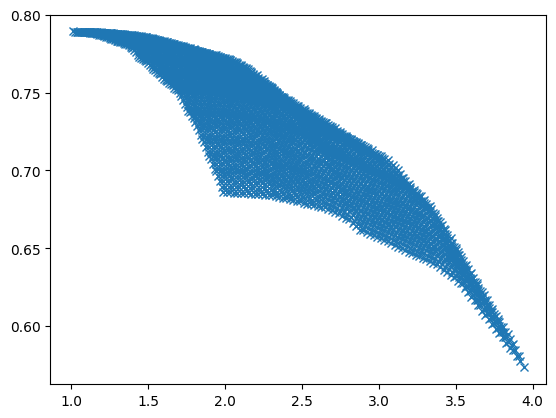

0.7892534090909091 26.287384090909097 0.07455454545454544
0.6825386363636363 24.04609431818182 0.11790568181818183
0.5622102272727273 21.840068181818182 0.172375
0.7732852272727274 25.93565113636364 0.08184431818181817
0.7130511363636365 24.20403409090909 0.10917386363636367


In [ ]:
# 你原来的循环代码
X = []
Y = []
best_ssim_1_5x = 0
best_ssim_2x = 0
best_ssim_3x = 0
best_psnr_1_5x = 0
best_psnr_2x = 0
best_psnr_3x = 0
best_lpips_2x = 9999
best_lpips_3x = 9999
best_lpips_1_5x = 9999

for i in range(len(cc)):
    for j in range(i+1, len(cc)):
        x4_ssim = np.array(all_ssim['4x'])[inds[:i]].sum()
        x2_ssim = np.array(all_ssim['2x'])[inds[i:j]].sum()
        x1_ssim = np.array(all_ssim['1x'])[inds[j:]].sum()
        tot_ssim = (x4_ssim + x2_ssim + x1_ssim) / len(cc)

        x4_psnr = np.array(all_psnr['4x'])[inds[:i]].sum()
        x2_psnr = np.array(all_psnr['2x'])[inds[i:j]].sum()
        x1_psnr = np.array(all_psnr['1x'])[inds[j:]].sum()
        tot_psnr = (x4_psnr + x2_psnr + x1_psnr) / len(cc)

        x4_lpips = np.array(all_lpips['4x'])[inds[:i]].sum()
        x2_lpips = np.array(all_lpips['2x'])[inds[i:j]].sum()
        x1_lpips = np.array(all_lpips['1x'])[inds[j:]].sum()
        tot_lpips = (x4_lpips + x2_lpips + x1_lpips) / len(cc)

        cr = (4*i + (j - i)*2 + (len(cc) - j)) / len(cc)
        X.append(cr)
        Y.append(tot_ssim)
        if abs(cr-2) <= 0.05 and tot_ssim > best_ssim_2x:
            best_ssim_2x = tot_ssim
            best_psnr_2x = tot_psnr
            best_lpips_2x = tot_lpips
        if abs(cr-3) <= 0.05 and tot_ssim > best_ssim_3x:
            best_ssim_3x = tot_ssim
            best_psnr_3x = tot_psnr
            best_lpips_3x = tot_lpips
        if abs(cr-1.5)<=0.05 and tot_ssim>best_ssim_1_5x:
            best_ssim_1_5x=tot_ssim
            best_psnr_1_5x=tot_psnr
            best_lpips_1_5x=tot_lpips

# 后面画图打印之类...
import matplotlib.pyplot as plt
plt.plot(X, Y, 'x')
plt.show()

print(np.array(all_ssim['1x']).mean(), np.array(all_psnr['1x']).mean(), np.array(all_lpips['1x']).mean())
print(np.array(all_ssim['2x']).mean(), np.array(all_psnr['2x']).mean(), np.array(all_lpips['2x']).mean())
print(np.array(all_ssim['4x']).mean(), np.array(all_psnr['4x']).mean(), np.array(all_lpips['4x']).mean())

print(best_ssim_2x, best_psnr_2x, best_lpips_2x)
print(best_ssim_3x, best_psnr_3x, best_lpips_3x)
print(best_ssim_1_5x, best_psnr_1_5x, best_lpips_1_5x)


In [17]:
cc=np.array(ci_ssim) # 1-ssim
inds=np.argsort(cc)

# SSIM

X=[]
Y=[]
best_ssim_2x=0
best_ssim_3x=0
best_psnr_2x=0
best_psnr_3x=0
best_lpips_2x=9999
best_lpips_3x=9999


for i in range(len(cc)):
    for j in range(i+1,len(cc)):
        x4_ssim=np.array(all_ssim['4x'])[inds[:i]].sum()
        x2_ssim=np.array(all_ssim['2x'])[inds[i:j]].sum()
        x1_ssim=np.array(all_ssim['1x'])[inds[j:]].sum()
        tot_ssim=(x4_ssim+x2_ssim+x1_ssim)/len(cc)

        x4_psnr=np.array(all_psnr['4x'])[inds[:i]].sum()
        x2_psnr=np.array(all_psnr['2x'])[inds[i:j]].sum()
        x1_psnr=np.array(all_psnr['1x'])[inds[j:]].sum()
        tot_psnr=(x4_psnr+x2_psnr+x1_psnr)/len(cc)

        x4_lpips=np.array(all_lpips['4x'])[inds[:i]].sum()
        x2_lpips=np.array(all_lpips['2x'])[inds[i:j]].sum()
        x1_lpips=np.array(all_lpips['1x'])[inds[j:]].sum()
        tot_lpips=(x4_lpips+x2_lpips+x1_lpips)/len(cc)

        cr=(4*i+(j-i)*2+(len(cc)-j))/len(cc)
        X.append(cr)
        Y.append(tot_ssim)
        if abs(cr-2)<=0.05 and tot_ssim>best_ssim_2x:
            best_ssim_2x=tot_ssim
            best_psnr_2x=tot_psnr
            best_lpips_2x=tot_lpips
        
        if abs(cr-3)<=0.05 and tot_ssim>best_ssim_3x:
            best_ssim_3x=tot_ssim
            best_psnr_3x=tot_psnr
            best_lpips_3x=tot_lpips

plt.plot(X,Y,'x')
plt.show()

print(np.array(all_ssim['1x']).mean(),np.array(all_psnr['1x']).mean(),np.array(all_lpips['1x']).mean())
print(np.array(all_ssim['2x']).mean(),np.array(all_psnr['2x']).mean(),np.array(all_lpips['2x']).mean())
print(np.array(all_ssim['4x']).mean(),np.array(all_psnr['4x']).mean(),np.array(all_lpips['4x']).mean())

print(best_ssim_2x,best_psnr_2x,best_lpips_2x)
print(best_ssim_3x,best_psnr_3x,best_lpips_3x)


NameError: name 'ci_ssim' is not defined